# Project 2


Name: HO, Chuen Ho	  
Student 20601111	  
Email: chhoba@connect.ust.hk    


Name: CHUN, Lok Him Brian    
Student ID: 20597138    
Email: lhbchun@connect.ust.hk   



In [ ]:
!git clone https://github.com/ymcui/Chinese-BERT-wwm.git

In [ ]:
!unzip "/content/drive/MyDrive/4995/weibo.zip" -d "/content/drive/MyDrive/4995"

Archive:  /content/drive/MyDrive/4995/weibo.zip
  inflating: /content/drive/MyDrive/4995/dev.csv  
  inflating: /content/drive/MyDrive/4995/test.csv  
  inflating: /content/drive/MyDrive/4995/train.csv  


In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses


In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chinese Bert

In [ ]:
import pandas as pd
import re
import numpy as np

In [ ]:
import torch

from IPython.display import clear_output
import random
from transformers import BertForMaskedLM
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2/" #hoho
#path = "/content/drive/MyDrive/4995/" #honeu

In [ ]:

dev = pd.read_csv(path+"dev.csv")

test = pd.read_csv(path+"test.csv")
test.to_csv(path+"final_test.tsv", sep="\t", index=False)

# 1 Preprocessing

In [ ]:
## TF-IDF

# Start with loading all necessary libraries
from os import path
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
import re
userdict_path = './data/dict.txt'
jieba.load_userdict(userdict_path)
stopwords_path = './data/stopword.txt'
# The function for processing text with Jieba
def jieba_processing_txt(text):

    mywordlist = []
    seg_list = jieba.lcut(text, cut_all=False, HMM=True)
    liststr = "/ ".join(seg_list)

    with open(stopwords_path, encoding='utf-8') as f_stop:
        f_stop_text = f_stop.read()
        f_stop_seg_list = f_stop_text.splitlines()

    stops=[]
    for myword in seg_list:
        if not (myword.strip() in f_stop_seg_list) and len(myword.strip()) > 1:
            mywordlist.append(myword.strip())
        else:
            stops.append(myword.strip())
    #print(stops)
    return mywordlist

tf_idf = []
idf = {}
for i in range(len(train["text"])):
    tf = {}
    for token in jieba_processing_txt(train["text"][i]):
        try:
            tf[token]+=1

        except:
            tf[token]=1
        try:
            idf[token]+=1
        except:
            idf[token]=1
    tf_idf.append(tf)


for i in range(len(tf_idf)):
    for token in tf_idf[i]:
        tf_idf[i][token] /= idf[token]

df_tfidf = pd.DataFrame(tf_idf).fillna(0)

keys = df_tfidf.columns
for key in keys:
    if '.' in key or ' ' in key or '%' in key:
        df_tfidf = df_tfidf.drop([key],axis = 1)


df_tfidf.to_csv("./data/vita_tfidf.csv", index = False)

## Extract Hashtag, Emoji, At

In [ ]:
train = pd.read_csv(path+"train.csv")
train.review = train.review+" "
train = pd.concat([train.review.str.replace("@(.*?)：|@(.*?):|@(.*?) |#(.*?)#|\[(.*?)\]|/",""),
                np.floor(train.review.str.count("#")/2),
                train.review.str.findall('#(.*?)#').transform(','.join), #hashtag
                train.review.str.findall('\[(.*?)\]').transform(','.join), #emoji
                train.review.str.count("\["),
                train.review.str.count("@"), 
                train.label] ,axis=1)
train = train.set_axis(['text','hashtag_count','hashtag','emoji','emoji_count','at_count','label'],axis=1)

train

,text,hashtag_count,hashtag,emoji,emoji_count,at_count,label
0,早起挂号这事实在不想再经历睡觉，早起，挂号,0.0,,"抓狂,睡觉",2,0,0
1,再见，美里！再见，Miri。在这个美丽的地方，我度过了难忘的假期。我会珍藏这份美好的记忆。...,1.0,托斯卡纳带你玩转砂劳越,"带着微博去旅行,爱你",2,5,1
2,结婚三周它一个酒瓶砸过来，给我开的口，伤至筋膜，缝了七针！然后它跑了，别人送我急诊的！那时候...,0.0,,"怒,怒,怒",3,2,0
3,想想地?油。有利益就有?狂。何??基因?外一?。祈?中? 转基因花生？又有新品种了。,0.0,,泪,1,2,0
4,Wow，我叫马云！ 林达！要是反过来就好了！ 林白，听起来还挺知性的吧，嘿嘿 冰儿 美马马,0.0,,"哈哈,馋嘴",2,4,1
...,...,...,...,...,...,...,...
99983,认同~外表的嚣张、叛逆恰恰是内心孱弱……内心足够强悍还用得着背后搞搞小动作？极度自卑与绝对自...,0.0,,哈哈,1,3,1
99984,我可以,0.0,,哈哈,1,0,1
99985,我们都应该互相体谅，哈哈,0.0,,哈哈,1,6,1
99986,姑娘，记得让孩子们学会唱一首好听的歌，让孩子们喝一口放心的奶。 支持你这种豁出去的行动和精神！,0.0,,哈哈,1,1,1


In [ ]:
print('post with hashtag:', (train.hashtag!='').sum())
print('post with emoji:', (train.emoji!='').sum())

post with hashtag: 8297
post with emoji: 99988


## Full dataset

In [ ]:
train, test = train_test_split(train, test_size=0.2, random_state=4995)
train_1, train_2 = train_test_split(train, test_size=0.2, random_state=4995)
train_2, train_3 = train_test_split(train_2, test_size=0.2, random_state=4995)
print(f'Training dataset 1:   {train_1.shape}')
print(f'Training dataset 2:   {train_2.shape}')
print(f'Training dataset 3:   {train_3.shape}')
print(f'Testing dataset:    {test.shape}')
train_1.to_csv(path+"train_1.tsv", sep="\t", index=False)
train_2.to_csv(path+"train_2.tsv", sep="\t", index=False)
train_3.to_csv(path+"train_3.tsv", sep="\t", index=False)
test.to_csv(path+"test.tsv", sep="\t", index=False)

Training dataset 1:   (63992, 7)
Training dataset 2:   (12798, 7)
Training dataset 3:   (3200, 7)
Testing dataset:    (19998, 7)


## shorted dataset

In [ ]:
MAX_LENGTH = 40
df_train = train[~(train.text.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train.reset_index().drop(['index'],axis=1)

In [ ]:
shorted_train, shorted_test = train_test_split(df_train, test_size=0.2, random_state=4995)
shorted_train_1, shorted_train_2 = train_test_split(shorted_train, test_size=0.2, random_state=4995)
shorted_train_2, shorted_train_3 = train_test_split(shorted_train_2, test_size=0.2, random_state=4995)
print(f'Training dataset 1:   {shorted_train_1.shape}')
print(f'Training dataset 2:   {shorted_train_2.shape}')
print(f'Training dataset 3:   {shorted_train_3.shape}')
print(f'Testing dataset:    {shorted_test.shape}')
shorted_train_1.to_csv(path+"shorted_train_1.tsv", sep="\t", index=False)
shorted_train_2.to_csv(path+"shorted_train_2.tsv", sep="\t", index=False)
shorted_train_3.to_csv(path+"shorted_train_3.tsv", sep="\t", index=False)
shorted_test.to_csv(path+"shorted_test.tsv", sep="\t", index=False)

Training dataset 1:   (31504, 7)
Training dataset 2:   (6301, 7)
Training dataset 3:   (1576, 7)
Testing dataset:    (9846, 7)


## Emoji dataset

In [ ]:
df_emoji_train = train
emoji_train, emoji_test = train_test_split(df_emoji_train, test_size=0.2, random_state=4995)
emoji_train_1, emoji_train_2 = train_test_split(emoji_train, test_size=0.2, random_state=4995)
emoji_train_2, emoji_train_3 = train_test_split(emoji_train_2, test_size=0.2, random_state=4995)
print(f'Training dataset 1:   {emoji_train_1.shape}')
print(f'Training dataset 2:   {emoji_train_2.shape}')
print(f'Training dataset 3:   {emoji_train_3.shape}')
print(f'Testing dataset:    {emoji_test.shape}')
emoji_train_1.to_csv(path+"emoji_train_1.tsv", sep="\t", index=False)
emoji_train_2.to_csv(path+"emoji_train_2.tsv", sep="\t", index=False)
emoji_train_3.to_csv(path+"emoji_train_3.tsv", sep="\t", index=False)
emoji_test.to_csv(path+"emoji_test.tsv", sep="\t", index=False)

Training dataset 1:   (51193, 7)
Training dataset 2:   (10239, 7)
Training dataset 3:   (2560, 7)
Testing dataset:    (15998, 7)


# 2 Bert Model demo

In [ ]:

PRETRAINED_MODEL_NAME = "bert-base-chinese"  # chinese BERT-BASE pre-train model

# tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)


Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:
vocab = tokenizer.vocab
print("Dictionary Size", len(vocab))
random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids):
    print("{0:15}{1:10}".format(t, id))

Dictionary Size 21128
token               index          
-------------------------
##蔥                 18977
##波                 16854
##钿                 20243
ィ                     590
jj                  11095
鉻                    7064
评                    6397
##顽                 20616
##克                 14103
##遁                 19932


## mask example and visualization

In [ ]:
text = "[CLS] 今晚的月色真[MASK] 。"
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)

print(text)
print(tokens[:10], '...')
print(ids[:10], '...')

[CLS] 今晚的月色真[MASK] 。
['[CLS]', '今', '晚', '的', '月', '色', '真', '[MASK]', '。'] ...
[101, 791, 3241, 4638, 3299, 5682, 4696, 103, 511] ...


In [ ]:
# create segment ids
tokens_tensor = torch.tensor([ids])  # (1, seq_len)
segments_tensors = torch.zeros_like(tokens_tensor)  # (1, seq_len)
maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)
clear_output()

# use masked LM guess actual token of [MASK] 
maskedLM_model.eval()
with torch.no_grad():
    outputs = maskedLM_model(tokens_tensor, segments_tensors)
    predictions = outputs[0]
    # (1, seq_len, num_hidden_units)
del maskedLM_model

# show top k possible tokens 
masked_index = 7
k = 3
probs, indices = torch.topk(torch.softmax(predictions[0, masked_index], -1), k)
predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())

# Show top result
print("Input tokens ：", tokens[:10], '...')
print("Translate: The moon tonight is so beautiful (BY google)")
print('-' * 50)
for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
    tokens[masked_index] = t
    print("Top {} ({:2}%)：{}".format(i, int(p.item() * 100), tokens[:10]), '...')

Input tokens ： ['[CLS]', '今', '晚', '的', '月', '色', '真', '[MASK]', '。'] ...
Translate: The moon tonight is so beautiful (BY google)
--------------------------------------------------
Top 1 (79%)：['[CLS]', '今', '晚', '的', '月', '色', '真', '美', '。'] ...
Top 2 (18%)：['[CLS]', '今', '晚', '的', '月', '色', '真', '好', '。'] ...
Top 3 ( 0%)：['[CLS]', '今', '晚', '的', '月', '色', '真', '佳', '。'] ...


In [ ]:
import sys
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

# import packages
from transformers import BertTokenizer, BertModel
from bertviz import head_view


def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

clear_output()

In [ ]:
# get chinese bert model
model_version = 'bert-base-chinese'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

# example sentence
sentence_a = "郭富城失去一切，他的家人證實了這一消息。"
#sentence_b = ""

# put tokens into BERT, receive an attention
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

# Bertviz do visualization
head_view(attention, tokens)



Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

# 3 Dataset and Dataloader

In [ ]:
class CommentDataset(Dataset):
    
    def __init__(self, mode, tokenizer):
        assert mode in ["train_1","train_2","train_3","test",
                        "shorted_train_1","shorted_train_2","shorted_train_3",'shorted_test',
                        "emoji_train_1","emoji_train_2","emoji_train_3","emoji_test",
                        'final_test','final_shorted_test','final_emoji_test']  
        self.mode = mode
        
        self.df = pd.read_csv(path+mode + ".tsv", sep="\t").fillna("")
        self.len = len(self.df)
        #self.label_map = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
        self.tokenizer = tokenizer  # BERT tokenizer
    
    # get a data
    def __getitem__(self, idx):
        if self.mode == "test" or self.mode == "shorted_test":
            text, hashtag_count, hashtag,  emoji,emoji_count, at_count = self.df.iloc[idx, :-1].values
            label_tensor = None
        elif self.mode == "emoji_test":
            text = self.df.iloc[idx, -4] #text here means emoji text
            label_tensor = None
        elif self.mode == "final_test"or self.mode =='final_shorted_test'or self.mode =='final_emoji_test':
            text = self.df.iloc[idx, 1]
            label_tensor = None
        elif self.mode == "emoji_train_1" or self.mode == "emoji_train_2" or self.mode == "emoji_train_3":
            text = self.df.iloc[idx, -4] #text here means emoji text
            label = self.df.iloc[idx, -1]
            label_tensor = torch.tensor(label)
        else:
            text, hashtag_count, hashtag,  emoji, emoji_count,at_count, label = self.df.iloc[idx, :].values
            
            #label_id = self.label_map[label]
            label_tensor = torch.tensor(label)
            
        # construct sentence start with [CLS] BERT tokens 
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens
        len_text = len(word_pieces)
        
        
        # convert token to search id
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        

        return (tokens_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    


In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    # check exists labels
    if samples[0][1] is not None:
        label_ids = torch.stack([s[1] for s in samples])
    else:
        label_ids = None
    
    # zero pad extend tensor to same length with others
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    
    # attention masks，mark tokens_tensors is not zero padding be 1
    # BERT will focus on tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, masks_tensors, label_ids



In [ ]:
!pwd

/content


## Example of dataloader

In [ ]:
    
# check funtionality of dataset
trainset = CommentDataset("shorted_train_3", tokenizer=tokenizer)

In [ ]:
# select first data
sample_idx = 0

text, hashtag_count, hashtag, emoji, emoji_count, at_count, label = trainset.df.iloc[sample_idx].values

# get the tensors
tokens_tensor, label_tensor = trainset[sample_idx]

# show original text
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)


print(f"""[Original text]
Sentence:{text}
Label  ：{label}

--------------------

[Dataset tensors]
tokens_tensor  ：{tokens_tensor}

label_tensor   ：{label_tensor}

--------------------

[Return tokens_tensors]
{combined_text}
""")

[Original text]
Sentence:回复多谢啦  
Label  ：1

--------------------

[Dataset tensors]
tokens_tensor  ：tensor([ 101, 1726, 1908, 1914, 6468, 1568])

label_tensor   ：1

--------------------

[Return tokens_tensors]
[CLS]回复多谢啦



In [ ]:
BATCH_SIZE=32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))

tokens_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------

------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([32, 39]) 
tensor([[ 101, 1726, 1908,  ...,    0,    0,    0],
        [ 101,  679, 2743,  ...,    0,    0,    0],
        [ 101, 6760, 1355,  ...,    0,    0,    0],
        ...,
        [ 101,  523,  100,  ...,    0,    0,    0],
        [ 101, 6821, 1126,  ...,    0,    0,    0],
        [ 101, 1920, 7391,  ...,    0,    0,    0]])
------------------------

------------------------
masks_tensors.shape    = torch.Size([32, 39])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        = torch.Size([32])
tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1])



#  4 Modelling

## Full model

In [ ]:
from transformers import BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

# modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=2, bias=True)


In [ ]:
class BertForSequenceClassification():
    def __init__(self, config, num_labels=2):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)  # loading BERT
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        #  linear 
        self.classifier = nn.Linear(config.hidden_size, num_labels)
          

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # BERT ( tokens, segments, masks)
        outputs = self.bert(input_ids, token_type_ids, attention_mask)
        
        pooled_output = self.dropout(pooled_output)
        
        logits = self.classifier(pooled_output)

        # Calculate entropy loss
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        # return attention matrix just in case
        elif self.output_attentions:
            return all_attentions, logits
        return logits

In [ ]:
# For saving and loading trained models
def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_acc': val_acc}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_acc']
    print(f'Model loaded from {save_path}, with val acc: {val_acc}')
    return val_acc

In [ ]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        # 
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            # 
            tokens_tensors, masks_tensors = data[:2]
            outputs = model(input_ids=tokens_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            # cal accuracy
            if compute_acc:
                labels = data[2]
                #print('labels',labels)
                total += labels.size(0)
                #print(labels.size(0),' ',total )
                correct += (pred == labels).sum().item()
                #print('pred ',pred)
                
            # record batch
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions
    


'''_, acc = get_predictions(model, trainloader, compute_acc=True)
print("classification acc:", acc)'''

'_, acc = get_predictions(model, trainloader, compute_acc=True)\nprint("classification acc:", acc)'

In [ ]:
# train
def Train(model, trainloader, num_epochs, optimizer, save_name, criterion=None, valid_mcc=None, device=None):
    
    if valid_mcc==None:
        best_valid_mcc = 0  
    else: 
        best_valid_mcc = valid_mcc
        print('Resume training')
    
    train_loss_log = []
    i=0
    model.train()
    print(len(trainloader))
    for epoch in range(num_epochs):

        running_loss = 0.0
        
        for data in trainloader:
            
            print(i)
            
            tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]

            
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(input_ids=tokens_tensors, 
                            attention_mask=masks_tensors, 
                            labels=labels)
            #print('get output')

            loss = outputs[0]
            # backward
            loss.backward()
            optimizer.step()


            # record batch loss
            running_loss += loss.item()
            i=i+1
            
            if i%10==0:
              train_loss_log.append(loss.item())
        # accuracy
        _, acc = get_predictions(model, trainloader, compute_acc=True)

        print('[epoch %d] loss: %.3f, acc: %.3f' %
              (epoch + 1, running_loss, acc))
        if acc > best_valid_mcc:
            best_valid_mcc = acc
            save_checkpoint(save_name, model, optimizer, best_valid_mcc)

    print('Finished Training')
    return train_loss_log

In [ ]:
def accuracy(predictions,test):    
    df = pd.DataFrame({"Predict label": predictions.tolist()})
    test = test.reset_index()
    df_pred = pd.concat([test['label'],df],axis=1)
    print('acc: %.3f' %  ((df_pred['label']==df_pred['Predict label']).sum()/len(df_pred)))


In [ ]:
save_name = ' bert_base_text'
#  Adam Optim 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
from transformers import BertForSequenceClassification
PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
class BertForSequenceClassification():
    def __init__(self, config, num_labels=2):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)  #  BERT
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # linear 
        self.classifier = nn.Linear(config.hidden_size, num_labels)
          

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        #
        outputs = self.bert(input_ids, token_type_ids, attention_mask)
        
        pooled_output = self.dropout(pooled_output)
        # s
        logits = self.classifier(pooled_output)

        # 
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        # 
        elif self.output_attentions:
            return all_attentions, logits
        return logits
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

trainset = CommentDataset("train_3", tokenizer=tokenizer)

# 
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)
EPOCHS = 10  # 
bert_base_text = Train(model=model,
                       trainloader=trainloader, 
                       num_epochs=EPOCHS, 
                       optimizer=optimizer, 
                       save_name=save_name,
                       device = device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

device: cuda:0
50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[epoch 1] loss: 34.771, acc: 0.524
Model saved to  bert_base_text
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


KeyboardInterrupt: ignored

In [ ]:
testset = CommentDataset("final_test", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)


predictions = get_predictions(model, testloader)

In [ ]:
test = pd.read_csv("final_test.tsv", sep="\t")
accuracy(predictions,test)

In [ ]:
train_3

,text,hashtag_count,hashtag,emoji,emoji_count,at_count,label
19561,哈哈，1画面音效服务继续保持一流，2从结伴同去的好友人脸一张baby图看，与依云合作的活动...,0.0,,"哈哈,哈哈,鼓掌,鼓掌,太阳,馋嘴,耶",7,3,1
94880,【今晚19：30播出大结局】雪舞为兰陵王挡箭……,1.0,兰陵王,泪,1,0,0
11610,回复上海飞可以订！请私信给 你好，想定2月2号左右去塞班的，7号左右回的航班…能定吗？成都上...,0.0,,"抓狂,抓狂,抓狂",3,5,0
53683,007出品，必属精品，最稀饭看台下幕后的花絮,1.0,张译,"爱你,花心",2,0,1
96575,这玩艺戴脸上还能防催泪弹 高科技新产品~ 敢附带个消音功能么！！,0.0,,"哈哈,挖鼻屎",2,3,1
...,...,...,...,...,...,...,...
15580,回乡下过年，这泥泞的小路。。。,0.0,,"泪,泪,泪",3,0,0
72486,回来时飞机晚点三个多小时，现在回去火车晚半小时，飞机又推迟近三小时才飞。闹怎样呀，这是? 我...,1.0,春运路上,晕,1,0,0
16545,我很桑心很桑心,0.0,,悲伤,1,0,0
65753,最近一周工作效率很低,0.0,,泪,1,0,0


## Reduced model

In [ ]:
from transformers import BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

class BertForSequenceClassification():
    def __init__(self, config, num_labels=2):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)  # 
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 
        self.classifier = nn.Linear(config.hidden_size, num_labels)
          

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # BERT 
        outputs = self.bert(input_ids, token_type_ids, attention_mask)
        
        pooled_output = self.dropout(pooled_output)
        # 
        logits = self.classifier(pooled_output)

        # 
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        # 
        elif self.output_attentions:
            return all_attentions, logits
        return logits

save_name = ' bert_reduced_text'
# 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

trainset = CommentDataset("shorted_train_2", tokenizer=tokenizer)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

# 
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)
EPOCHS = 10  #
bert_reduced_text = Train(model=model,
                       trainloader=trainloader, 
                       num_epochs=EPOCHS, 
                       optimizer=optimizer, 
                       save_name=save_name,
                       device = device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

device: cuda:0
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
[epoch 1] loss: 58.619, acc: 0.757
Model saved to  bert_reduced_text
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
[epoch 2] loss: 49.294, acc: 0.793
Model saved to  bert_reduced_text
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
23

In [ ]:
final_test = pd.read_csv(path+"final_test.tsv", sep='\t')

final_shorted_test = pd.concat([final_test[['label']],final_test.review],axis=1)
final_shorted_test.to_csv(path+"final_shorted_test.tsv", sep="\t", index=False)

In [ ]:
testset = CommentDataset("final_shorted_test", tokenizer=tokenizer) #if we could get the emoji
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)


predictions = get_predictions(model, testloader)
test = pd.read_csv(path+"final_test.tsv", sep="\t") 
accuracy(predictions,test)

acc: 0.821


In [ ]:
testset = CommentDataset("final_shorted_test", tokenizer=tokenizer) #if we could get the emoji
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)


predictions = get_predictions(model, testloader)
test = pd.read_csv(path+"final_test.tsv", sep="\t") 
accuracy(predictions,test)

acc: 0.836


acc: 0.813


## Emoji text model

In [ ]:
from transformers import BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

class BertForSequenceClassification():
    def __init__(self, config, num_labels=2):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)  # 
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # 
        self.classifier = nn.Linear(config.hidden_size, num_labels)
          

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # 
        outputs = self.bert(input_ids, token_type_ids, attention_mask)
        
        pooled_output = self.dropout(pooled_output)
        # 
        logits = self.classifier(pooled_output)

        # 
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        # 
        elif self.output_attentions:
            return all_attentions, logits
        return logits



In [ ]:
save_name = ' bert_emoji_text'
# 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

trainset = CommentDataset("emoji_train_2", tokenizer=tokenizer)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

# 
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)
EPOCHS = 5  # 
bert_emoji_text = Train(model=model,
                       trainloader=trainloader, 
                       num_epochs=EPOCHS, 
                       optimizer=optimizer, 
                       save_name=save_name,
                       device = device)

In [ ]:
final_test = pd.read_csv(path+"final_test.tsv", sep='\t')

final_emoji_test = pd.concat([final_test[['label']],final_test.review.str.findall('\[(.*?)\]').transform(','.join)],axis=1)
final_emoji_test.to_csv(path+"final_emoji_test.tsv", sep="\t", index=False)

In [ ]:
testset = CommentDataset("final_emoji_test", tokenizer=tokenizer) #if we could get the emoji
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)


predictions = get_predictions(model, testloader)
test = pd.read_csv(path+"final_test.tsv", sep="\t") 
accuracy(predictions,test)

acc: 0.983


In [ ]:
testset = CommentDataset("final_test", tokenizer=tokenizer)#if we could not get the emoji
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)

predictions = get_predictions(model, testloader)
test = pd.read_csv(path+"final_test.tsv", sep="\t") 
accuracy(predictions,test)

acc: 0.932


[1, 2, 3, 4, 5]

# 5 Visualization

In [ ]:
import matplotlib.pyplot as plt
#bert_base_text#plt.plot(range(1,198),bert_base_text[:], 'r')

In [ ]:
plt.plot(range(1,11),bert_reduced_text[:], 'r')

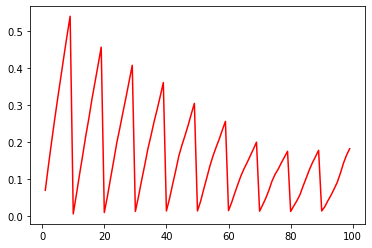

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(range(1,100),bert_reduced_text[:], 'r')
plt.show()
plt.savefig('bert_reduced_text.png')

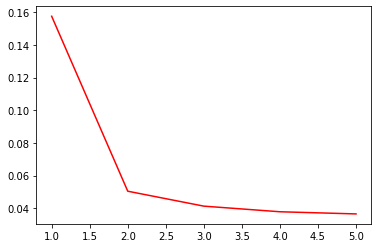

In [ ]:
plt.plot(bert_emoji_text[5],bert_emoji_text[:5], 'r')

#English Bert

In [ ]:
!pip install -U torchtext

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2/" #hoho
#path = "/content/drive/MyDrive/4995/" #honeu

# 1 Preprocessing

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
df = pd.read_csv(path+'weibo_senti_100k_translated.csv')
df = df.iloc[:,[1,3]]
df = df.sample(frac=1).reset_index(drop=True)
df_EN = pd.concat([df.review_translated,
                   df.review_translated.str.findall('\[(.*?)\]').transform(','.join),
                   df.label],axis=1)
df_EN = df_EN.set_axis(['review_translated','emoji','label'],axis=1)

In [ ]:
df_EN[['review_translated','label']].to_csv(path+"df_EN_text.tsv", sep="\t", index=False)
df_train = df_EN[~(df_EN.review_translated.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train.reset_index().drop(['index'],axis=1)
df_train[['review_translated','label']].to_csv(path+"df_EN_reduced_text.tsv", sep="\t", index=False)
df_EN[['emoji','label']].to_csv(path+"df_EN_emoji.tsv", sep="\t", index=False)


## Full dataset

In [ ]:
EN_train, EN_test = train_test_split(df_EN[['review_translated','label']], test_size=0.2, random_state=4995)
EN_train_1, EN_train_2 = train_test_split(EN_train, test_size=0.2, random_state=4995)
EN_train_2, EN_train_3 = train_test_split(EN_train_2, test_size=0.2, random_state=4995)
print(f'Training dataset 1:   {EN_train_1.shape}')
print(f'Training dataset 2:   {EN_train_2.shape}')
print(f'Training dataset 3:   {EN_train_3.shape}')
print(f'Testing dataset:    {EN_test.shape}')
EN_train_1.to_csv(path+"EN_train_1.tsv", sep="\t", index=False)
EN_train_2.to_csv(path+"EN_train_2.tsv", sep="\t", index=False)
EN_train_3.to_csv(path+"EN_train_3.tsv", sep="\t", index=False)
EN_test.to_csv(path+"EN_test.tsv", sep="\t", index=False)

## Shorted dataset

In [ ]:
MAX_LENGTH = 150
df_train = df_EN[~(df_EN.review_translated.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train.reset_index().drop(['index'],axis=1)
df_train

,review_translated,emoji,label
0,To @懒懒de小狮 @benbenvsyebing said: It’s nice to ...,love you,1
1,Love Tour //@遨游网99gg: Children's shoes in Beij...,tears,0
2,I am the only one left in this hospital at thi...,tears,0
3,[Love you] @游局网: Beautiful encounter... @北京胡同印...,Love you,1
4,[Too happy] Looking forward to the feature film!,Too happy,1
...,...,...,...
63442,"Excessive stimulation, people 2.5, let's 5. [C...","Crazed,crazed,crazed,crazed",0
63443,"During this time, my mother is really working ...",爱你,1
63444,Give it to 223... [tears],tears,0
63445,Goddess [tears],tears,0


In [ ]:
shorted_train, shorted_test = train_test_split(df_train[['review_translated','label']], test_size=0.2, random_state=4995)
shorted_train_1, shorted_train_2 = train_test_split(shorted_train, test_size=0.2, random_state=4995)
shorted_train_2, shorted_train_3 = train_test_split(shorted_train_2, test_size=0.2, random_state=4995)
print(f'Training dataset 1:   {shorted_train_1.shape}')
print(f'Training dataset 2:   {shorted_train_2.shape}')
print(f'Training dataset 3:   {shorted_train_3.shape}')
print(f'Testing dataset:    {shorted_test.shape}')
shorted_train_1.to_csv(path+"EN_shorted_train_1.tsv", sep="\t", index=False)
shorted_train_2.to_csv(path+"EN_shorted_train_2.tsv", sep="\t", index=False)
shorted_train_3.to_csv(path+"EN_shorted_train_3.tsv", sep="\t", index=False)
shorted_test.to_csv(path+"EN_shorted_test.tsv", sep="\t", index=False)

Training dataset 1:   (40605, 2)
Training dataset 2:   (8121, 2)
Training dataset 3:   (2031, 2)
Testing dataset:    (12690, 2)


## Emoji dataset

In [ ]:
df_emoji_train = df_EN[['emoji','label']]
emoji_train, emoji_test = train_test_split(df_emoji_train, test_size=0.2, random_state=4995)
emoji_train_1, emoji_train_2 = train_test_split(emoji_train, test_size=0.2, random_state=4995)
emoji_train_2, emoji_train_3 = train_test_split(emoji_train_2, test_size=0.2, random_state=4995)
print(f'Training dataset 1:   {emoji_train_1.shape}')
print(f'Training dataset 2:   {emoji_train_2.shape}')
print(f'Training dataset 3:   {emoji_train_3.shape}')
print(f'Testing dataset:    {emoji_test.shape}')
emoji_train_1.to_csv(path+"EN_emoji_train_1.tsv", sep="\t", index=False)
emoji_train_2.to_csv(path+"EN_emoji_train_2.tsv", sep="\t", index=False)
emoji_train_3.to_csv(path+"EN_emoji_train_3.tsv", sep="\t", index=False)
emoji_test.to_csv(path+"EN_emoji_test.tsv", sep="\t", index=False)

Training dataset 1:   (76792, 2)
Training dataset 2:   (15358, 2)
Training dataset 3:   (3840, 2)
Testing dataset:    (23998, 2)


## torchtext method

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 150
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields_text = [('review_translated', text_field), ('label', label_field) ]
fields_emoji = [('emoji', text_field), ('label', label_field) ]
# TabularDataset

EN_text_train, EN_text_valid, EN_text_test = TabularDataset.splits(path=path, train='EN_train_2.tsv', 
                                           validation='EN_train_3.tsv',
                                           test='EN_test.tsv', 
                                           format='TSV', fields=fields_text, skip_header=True)
EN_reduced_text_train, EN_reduced_text_valid, EN_reduced_text_test = TabularDataset.splits(path=path, 
                                           train='EN_shorted_train_2.tsv', 
                                           validation='EN_shorted_train_3.tsv',
                                           test='EN_shorted_test.tsv', 
                                           format='TSV', fields=fields_text, skip_header=True)
EN_emoji_train, EN_emoji_valid, EN_emoji_test = TabularDataset.splits(path=path,
                                           train='EN_emoji_train_2.tsv', 
                                           validation='EN_emoji_train_3.tsv',
                                           test='EN_emoji_test.tsv', 
                                           format='TSV', fields=fields_text, skip_header=True)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Iterators

full_train_iter = BucketIterator(EN_text_train, batch_size=64, sort_key=lambda x: len(x.review_translated),
                            device=device, train=True, sort=True, sort_within_batch=True)
full_valid_iter = BucketIterator(EN_text_valid, batch_size=64, sort_key=lambda x: len(x.review_translated),
                            device=device, train=True, sort=True, sort_within_batch=True)
full_test_iter = Iterator(EN_text_test, batch_size=64, device=device, train=False, shuffle=False, sort=False)

In [ ]:
reduced_train_iter = BucketIterator(EN_reduced_text_train, batch_size=64, sort_key=lambda x: len(x.review_translated),
                            device=device, train=True, sort=True, sort_within_batch=True)
reduced_valid_iter = BucketIterator(EN_reduced_text_valid, batch_size=64, sort_key=lambda x: len(x.review_translated),
                            device=device, train=True, sort=True, sort_within_batch=True)
reduced_test_iter = Iterator(EN_reduced_text_test, batch_size=64, device=device, train=False, shuffle=False, sort=False)

In [ ]:
emoji_train_iter = BucketIterator(EN_emoji_train, batch_size=64, sort_key=lambda x: len(x.review_translated),
                            device=device, train=True, sort=True, sort_within_batch=True)
emoji_valid_iter = BucketIterator(EN_emoji_valid, batch_size=64, sort_key=lambda x: len(x.review_translated),
                            device=device, train=True, sort=True, sort_within_batch=True)
emoji_test_iter = Iterator(EN_emoji_test, batch_size=64, device=device, train=False, shuffle=False, sort=False)

# 2 Model

In [ ]:

class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [ ]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def Train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          criterion = nn.BCELoss(),
          num_epochs = 3,
          file_path = path,
          best_valid_loss = float("Inf")):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
           #print("glob",type(global_step))
            #print("eva;_every",type(eval_every))
            if global_step % (len(train_loader)//2) == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / (len(train_loader)//2)
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'reduced_model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'reduced_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'reduced_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')



In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    


## Emoji

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Train(model=model,train_loader=reduced_train_iter,valid_loader=reduced_valid_iter, optimizer=optimizer)

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Train(model=model,train_loader=emoji_train_iter,valid_loader=emoji_valid_iter, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/3], Step [120/720], Train Loss: 0.4012, Valid Loss: 0.6841
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//metrics.pt
Epoch [1/3], Step [240/720], Train Loss: 0.2931, Valid Loss: 0.1571
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//metrics.pt
Epoch [2/3], Step [360/720], Train Loss: 0.0767, Valid Loss: 0.1893
Epoch [2/3], Step [480/720], Train Loss: 0.1646, Valid Loss: 0.1102
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//metrics.pt
Epoch [3/3], Step [600/720], Train Loss: 0.0536, Valid Loss: 0.0902
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//model.pt
Model saved to ==> /content/drive/MyDr

### visual

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//metrics.pt


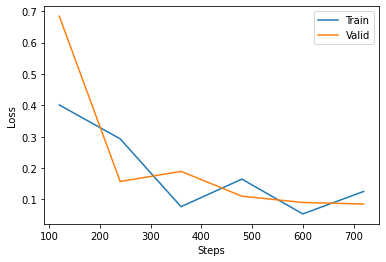

In [ ]:

train_loss_list, valid_loss_list, global_steps_list = load_metrics(path + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
best_model = BERT().to(device)

load_checkpoint(path + '/model.pt', best_model)

evaluate(best_model, emoji_test_iter)

## Reduced 

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Train(model=model,train_loader=reduced_train_iter,valid_loader=reduced_valid_iter, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/3], Step [63/381], Train Loss: 0.4978, Valid Loss: 0.1785
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_metrics.pt
Epoch [1/3], Step [126/381], Train Loss: 0.1466, Valid Loss: 0.0983
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_metrics.pt
Epoch [2/3], Step [189/381], Train Loss: 0.0561, Valid Loss: 0.0998
Epoch [2/3], Step [252/381], Train Loss: 0.0794, Valid Loss: 0.1300
Epoch [3/3], Step [315/381], Train Loss: 0.0449, Valid Loss: 0.0985
Epoch [3/3], Step [378/381], Train Loss: 0.0597, Valid Loss: 0.0837
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_metrics.pt
Model saved

### visual

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_metrics.pt


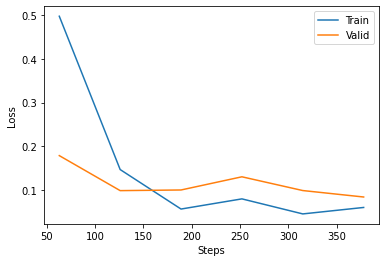

In [ ]:
 
train_loss_list, valid_loss_list, global_steps_list = load_metrics(path + '/reduced_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Math 4995 Project 2//reduced_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9769    0.9774    0.9772      6629
           0     0.9752    0.9748    0.9750      6061

    accuracy                         0.9761     12690
   macro avg     0.9761    0.9761    0.9761     12690
weighted avg     0.9761    0.9761    0.9761     12690



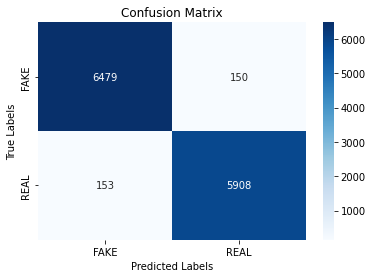

In [ ]:
best_model = BERT().to(device)

load_checkpoint(path + '/reduced_model.pt', best_model)

evaluate(best_model, reduced_test_iter)

# DIY Model

In [ ]:
!pip install deep_translator

     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.3 which is incompatible.


In [ ]:
import pandas as pd
from deep_translator import GoogleTranslator as Translator


import nltk
nltk.download('punkt')
from nltk import word_tokenize

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import confusion_matrix as confMatrix
from sklearn.metrics import accuracy_score as scoreThis


translator = Translator(source='zh-cn', target='en') #The Translator
fileName = "weibo_senti_100k_translated.csv"

dat = pd.read_csv(fileName) #Read the file
#print(dat)

#translationVar = dat
#119988 rows × 3 columns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


FileNotFoundError: ignored

Note: the below chunk will run for roughly 30 hours and will interrupt if any of the iterration fail for any reason from Google. It is used for generation of translated text.

In [ ]:
# def TranslateText(row):
#     translationVar.loc[row,'review_translated'] = translator.translate(dat['review'][i], dest='en')


# for i in range(0,119988):
#     TranslateText(i)
#     if i%10 == 0:
#         print("Finished " + str(i) + "th row of translation")

# Preprocess Data
The below function shows the preprocess of data. function `preprocessData` split the data into 80% training and 20% testing. 
Also, when `OnTranslated` is true, X is translated text. Otherwise, X is Chinese text.

The `score` function gives accuracy and confusion matrix.

In [ ]:
# split the data into 1 with only positive review and 1 with negative review
X, Y, X_forScore, Y_forScore = None, None, None, None
def preprocessData(OnTranslated):
    global X, Y, X_forScore, Y_forScore
    positive_review = dat[dat["label"] == 1]
    negative_review = dat[dat["label"] == 0]

    #split the data into 80% training and 20% testing
    
    if OnTranslated:
        positiveTrainX, positiveTestX, positiveTrainY, positiveTestY = tts(positive_review['review_translated'], positive_review['label'], test_size = 0.2, random_state = 4995)
        negativeTrainX, negativeTestX, negativeTrainY, negativeTestY = tts(negative_review['review_translated'], negative_review['label'], test_size = 0.2, random_state = 4995)
    else:
        positiveTrainX, positiveTestX, positiveTrainY, positiveTestY = tts(positive_review['review'], positive_review['label'], test_size = 0.2, random_state = 4995)
        negativeTrainX, negativeTestX, negativeTrainY, negativeTestY = tts(negative_review['review'], negative_review['label'], test_size = 0.2, random_state = 4995)

    X = positiveTrainX.append(negativeTrainX)
    X_forScore = positiveTestX.append(negativeTestX)
    Y = positiveTrainY.append(negativeTrainY)
    Y_forScore = positiveTestY.append(negativeTestY)


def score(actual, prediction):
    print(confMatrix(actual, prediction))
    print(scoreThis(actual, prediction))

## KNN Algorithm (k = 1, 1-norm)
Traditional KNN try to find closest similarity of reviews, while this algorithm tries to score positive and negative review and find the closest distance to "1" or "0"

Below we would create a scoring system for each of the character:
- If the character exist in positive review, the character optains a score of 1/len(i)
- If the character exist in negative review, the character loses a score of 1/len(i)

Then, the sign of the score of prediction would be the result (+: positive review, -:negative review)

In [ ]:
class KNN():
       
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    def fit(this,X,Y):
        
        count = 0 # To report on progress on training since it is slow
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            label = Y[i]
            length = len(v)
            
            for j in range(0, length): # For each character
                targetChar = X[i][j]
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [0], 1: [0]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1/length
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        newDataStruc = {0: [0], 1: [0]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            length = len(v)
            score = pd.DataFrame(data = newDataStruc)
            
            for j in range(0, length):
                targetChar = X[i][j]
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] + this.house_score[0][targetChar]
                    score[1] = score[1] + this.house_score[1][targetChar]
                    
                except KeyError:
                    pass
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

NameError: ignored

## KNN English (k = 1, 1-norm)
The same algorithm as above but the model is adopted for English characters.

In [ ]:
class KNN_English():
    
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    def fit(this,X,Y):
        count = 0
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            label = Y[i]
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens: # For each character
                targetChar = j
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [0], 1: [0]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1/length
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        
        newDataStruc = {0: [0], 1: [0]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            
            score = pd.DataFrame(data = newDataStruc)
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens:
                targetChar = j
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] + this.house_score[0][targetChar]
                    score[1] = score[1] + this.house_score[1][targetChar]
                    
                except KeyError:
                    pass
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

## KNN Algorithm (k = 1, 2-norm)
As the above algorithm can be treated as KNN, it might be worthy to test it again with 2 norm. Compare with the above model, 2-norm KNN will put higher emphasis on words that have higher occurance in training set (i.e., the words are more frequent to be used on positive/negative expressions)

In [ ]:
class KNN2():
       
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    def fit(this,X,Y):
        
        count = 0 # To report on progress on training since it is slow
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            label = Y[i]
            length = len(v)
            
            for j in range(0, length): # For each character
                targetChar = X[i][j]
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [0], 1: [0]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1/length
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        newDataStruc = {0: [0], 1: [0]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            length = len(v)
            score = pd.DataFrame(data = newDataStruc)
            
            for j in range(0, length):
                targetChar = X[i][j]
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] + this.house_score[0][targetChar]*this.house_score[0][targetChar]
                    score[1] = score[1] + this.house_score[1][targetChar]*this.house_score[1][targetChar]
                    
                except KeyError:
                    pass
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

## KNN English (k = 1, 2-norm)
The same algorithm as above but the model is adopted for English characters.

In [ ]:
class KNN2_English():
    
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    def fit(this,X,Y):
        count = 0
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            label = Y[i]
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens: # For each character
                targetChar = j
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [0], 1: [0]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1/length
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        
        newDataStruc = {0: [0], 1: [0]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            
            score = pd.DataFrame(data = newDataStruc)
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens:
                targetChar = j
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] + this.house_score[0][targetChar]*this.house_score[0][targetChar]
                    score[1] = score[1] + this.house_score[1][targetChar]*this.house_score[1][targetChar]
                    
                except KeyError:
                    pass
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

## Naive Bayes
Naive Bayes Classification is often introduced with the example of scam email, which can be seen as an NLP example. Therefore, it might be possible that Naive Bayes is useful for NLP.

The following model use the concept of Naive Bayes along with laplace smoothing. (Note: Laplace smoothing is useful for rare word where word in testing set is not found in training set. In fact, in terms of programming, using laplace smoothing can also avoid quite a lot of exception handling in calculation.)

In [ ]:
class naive_bayes():
    
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    
    def fit(this,X,Y):
        count = 0
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            label = Y[i]
            length = len(v)
            
            for j in range(0, length): # For each character
                targetChar = X[i][j]
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [1], 1: [1]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        
        newDataStruc = {0: [1], 1: [1]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            length = len(v)
            score = pd.DataFrame(data = newDataStruc)
            
            for j in range(0, length):
                targetChar = X[i][j]
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] * this.house_score[0][targetChar]
                except KeyError:
                    pass
                
                try:
                    t = this.house_score[0][targetChar]
                    score[1] = score[1] * this.house_score[1][targetChar]
                except KeyError:
                    pass
                
                
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

## Naive Bayes English
The same algorithm as above but the model is adopted for English characters.

In [ ]:
class naive_bayes_English():
    
    
    struc = {0: [], 1: []}
    newDataStruc = {0: [0], 1: [0]}
    house_score = pd.DataFrame(data = struc)
    
    
    def fit(this,X,Y):
        count = 0
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            label = Y[i]
            
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens: # For each character
                targetChar = j
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [1], 1: [1]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        
        newDataStruc = {0: [1], 1: [1]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            score = pd.DataFrame(data = newDataStruc)
            
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens:
                targetChar = j
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] * this.house_score[0][targetChar]
                except KeyError:
                    pass
                
                try:
                    t = this.house_score[0][targetChar]
                    score[1] = score[1] * this.house_score[1][targetChar]
                except KeyError:
                    pass
                
                
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

## Training and Testing models
**Note: For each of the mode, it takes long time on both training and testing (ranging from roughly 15-45 minutes for each training OR testing phase). Therefore, it is not recommended to run for immediate results**

Below lines are for training and testing above models.

In [ ]:
X, Y, X_forScore, Y_forScore = None, None, None, None
#Training Chinese Model First
preprocessData(OnTranslated = False)

#Classes
model_knn = KNN()
model_knn2 = KNN2()
model_nb = naive_bayes()

#Training Phase
print("Fitting KNN")
model_knn.fit(X,Y)

print("Fitting KNN2")
model_knn2.fit(X,Y)

print("Fitting Bayes")
model_nb.fit(X,Y)

Testing Phase

In [ ]:
#Training Accuracy
print("Predicting KNN (Train)")
trainResult_knn = model_knn.predict(X)

print("Predicting KNN2 (Train)")
trainResult_knn2 = model_knn2.predict(X)

print("Predicting Bayes (Train)")
trainResult_nb = model_nb.predict(X)



#Testing Accuracy
print("Predicting KNN (Test)")
testResult_knn = model_knn.predict(X_forScore)

print("Predicting KNN2 (Test)")
testResult_knn2 = model_knn2.predict(X_forScore)

print("Predicting Bayes (Test)")
testResult_nb = model_nb.predict(X_forScore)

Scoring

In [ ]:
#Scoring
print("Score of KNN (Train)")
score(Y, trainResult_knn)

print("Score of KNN2 (Train)")
score(Y, trainResult_knn2)

print("Score of Bayes (Train)")
score(Y, trainResult_nb)

#Scoring
print("Score of KNN (Test)")
score(Y_forScore, testResult_knn)

print("Score of KNN2 (Test)")
score(Y_forScore, testResult_knn2)

print("Score of Bayes (Test)")
score(Y_forScore, testResult_nb)

Training for English

In [ ]:
#Training English Model
preprocessData(OnTranslated = True)

#Classes
model_knnE = KNN_English()
model_knn2E = KNN2_English()
model_nbE = naive_bayes_English()

#Training Phase
print("Fitting KNN_English")
model_knnE.fit(X,Y)

print("Fitting KNN2_English")
model_knn2E.fit(X,Y)

print("Fitting Bayes_English")
model_nbE.fit(X,Y)

Testing Phase

In [ ]:
#Training Accuracy
print("Predicting KNN_English (Train)")
trainResult_knnE = model_knnE.predict(X)

print("Predicting KNN2_English (Train)")
trainResult_knn2E = model_knn2E.predict(X)

print("Predicting Bayes_English (Train)")
trainResult_nbE = model_nbE.predict(X)



#Testing Accuracy
print("Predicting KNN_English (Test)")
testResult_knnE = model_knnE.predict(X_forScore)

print("Predicting KNN2_English (Test)")
testResult_knn2E = model_knn2E.predict(X_forScore)

print("Predicting Bayes_English (Test)")
testResult_nbE = model_nbE.predict(X_forScore)

Scoring

In [ ]:
#Scoring
print("Score of KNN_English (Train)")
score(Y, trainResult_knnE)

print("Score of KNN2_English (Train)")
score(Y, trainResult_knn2E)

print("Score of Bayes_English (Train)")
score(Y, trainResult_nbE)

#Scoring
print("Score of KNN_English (Test)")
score(Y_forScore, testResult_knnE)

print("Score of KNN2_English (Test)")
score(Y_forScore, testResult_knn2E)

print("Score of Bayes_English (Test)")
score(Y_forScore, testResult_nbE)

Miscelleneous

In [ ]:
model_knn.house_score

In [ ]:
model_knn2.house_score

In [ ]:
model_nb.house_score

In [ ]:
model_knnE.house_score

In [ ]:
model_knn2E.house_score

In [ ]:
model_nbE.house_score

## Question: does a norm with lower value looks better?

In [ ]:
class KNNX():
    norm = 1
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    def __init__(this, n):
        this.norm = n
    
    def fit(this,X,Y):
        
        count = 0 # To report on progress on training since it is slow
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            label = Y[i]
            length = len(v)
            
            for j in range(0, length): # For each character
                targetChar = X[i][j]
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [0], 1: [0]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1/length
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        newDataStruc = {0: [0], 1: [0]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            length = len(v)
            score = pd.DataFrame(data = newDataStruc)
            
            for j in range(0, length):
                targetChar = X[i][j]
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] + this.house_score[0][targetChar] ** this.n
                    score[1] = score[1] + this.house_score[1][targetChar] ** this.n
                    
                except KeyError:
                    pass
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

In [ ]:
#smaller norm looks better?
#Note: 0-norm is useless because 0^0 = 1 in python
preprocessData(OnTranslated = False)
model_knnx = KNNX(0)
model_knnx.fit(X,Y)
for i in range(10):
    model_knnx.n = i / 10
    testResult_knnx = model_knnx.predict(X_forScore)
    print("Predicting with norm = " + str(i/10))
    score(Y_forScore, testResult_knnx)

In [ ]:
#plot
import matplotlib.pyplot as plt
knn_norms = [[0.906533877823152, 0.9095757979831652,0.9084923743645303,0.9051587632302692,0.9004500375031252,0.8956163013584465
              ,0.8889907492291024,0.8889907492291024,0.8813234436203017,0.860446703891991,0.7426868905742146],
            [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]]
plt.plot(knn_norms[1],knn_norms[0])

For English

In [ ]:
class KNNX_English():
    norm = 1
    struc = {0: [], 1: []}
    house_score = pd.DataFrame(data = struc)
    
    def __init__(this, n):
        this.norm = n
    
    def fit(this,X,Y):
        
        count = 0 # To report on progress on training since it is slow
        this.house_score = pd.DataFrame(data = this.struc) #empty DataFrame
        
        for i,v in X.iteritems(): # For each row
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            label = Y[i]
            tokens = word_tokenize(v)
            length = len(tokens)
            
            for j in tokens: # For each character
                targetChar = j
                try: #If it already exist then no need to do anything
                    t = this.house_score[label][targetChar]
                except KeyError: # Otherwise append a new index
                    newDataStruc = pd.DataFrame({0: [0], 1: [0]}, index = [targetChar])
                    this.house_score = this.house_score.append(newDataStruc)
                    
                addScore = 1/length
                this.house_score[label][targetChar] = this.house_score[label][targetChar] + addScore
    
    def predict(this,X):
        
        count = 0
        newDataStruc = {0: [0], 1: [0]}
        result = []
        
        for i,v in X.iteritems(): # For each row
            
            count = count + 1
            if count % 1000 == 0:
                print("Finished " + str(count) + "th iteration.")
            
            length = len(v)
            score = pd.DataFrame(data = newDataStruc)
            
            for j in range(0, length):
                targetChar = X[i][j]
                
                try:
                    t = this.house_score[0][targetChar]
                    score[0] = score[0] + this.house_score[0][targetChar] ** this.n
                    score[1] = score[1] + this.house_score[1][targetChar] ** this.n
                    
                except KeyError:
                    pass
                
            if score[1][0] > score[0][0]:
                result.append(1)
            else:
                result.append(0)
        
        return result

In [ ]:
#smaller norm looks better?
preprocessData(OnTranslated = True)
model_knnxE = KNNX_English(0)
model_knnxE.fit(X,Y)
for i in range(10):
    model_knnxE.n = i / 10
    testResult_knnxE = model_knnxE.predict(X_forScore)
    print("Predicting with norm = " + str(i/10))
    score(Y_forScore, testResult_knnxE)

# Free google colab memory

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU


  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=c48e0172b5180320ad5ee9681e10b906defa6f5bc380bdac51e6b6d98f43ac5b
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.0 GB  | Proc size: 4.8 GB
GPU RAM Free: 54MB | Used: 11387MB | Util 100% | Total 11441MB
